# Capstone 3 - Customer Churn Prediction for Telco

In our previous [Notebook](https://github.com/dvanheeswijk/Springboard/blob/master/Capstone_3/Capstone%203%20-%20EDA.ipynb), we explored our data set to find any possible leads to areas to focus on for our modeling. We found that bigger cities had larger churn volumes, while a few cities also had much higher percentages of churn than most others, specifically smaller cities with a handful of customers. We also saw that Fiber Optics customers were almost twice as likely to churn as DSL customers or customers with no internet service. Lastly, we saw that the primary reasons for leaving were basically either competitive offers from other companies or poor service attitude when dealing with troubleshooting issues. 

We will now explore *clean_data.csv*, our preprocessed data set and create training and testing data sets in order to evaluate models.

We start with importing the data and necessary libraries.

In [1012]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
# from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve,scorer
from sklearn.feature_selection import SelectKBest

In [1013]:
data = pd.read_csv('data/clean_data.csv')

data.head()

,CustomerID,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Internet Service_DSL,Internet Service_Fiber optic,Internet Service_No,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,3668-QPYBK,90003,33.964131,-118.272783,0,0,0,0,2,1,...,1,0,0,1,0,0,0,0,0,1
1,9237-HQITU,90005,34.059281,-118.307420,1,0,0,1,2,1,...,0,1,0,1,0,0,0,0,1,0
2,9305-CDSKC,90006,34.048013,-118.293953,1,0,0,1,8,1,...,0,1,0,1,0,0,0,0,1,0
3,7892-POOKP,90010,34.062125,-118.315709,1,0,1,1,28,1,...,0,1,0,1,0,0,0,0,1,0
4,0280-XJGEX,90015,34.039224,-118.266293,0,0,0,1,49,1,...,0,1,0,1,0,0,1,0,0,0


In [1014]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 32 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CustomerID                                7032 non-null   object 
 1   Zip Code                                  7032 non-null   int64  
 2   Latitude                                  7032 non-null   float64
 3   Longitude                                 7032 non-null   float64
 4   Gender                                    7032 non-null   int64  
 5   Senior Citizen                            7032 non-null   int64  
 6   Partner                                   7032 non-null   int64  
 7   Dependents                                7032 non-null   int64  
 8   Tenure Months                             7032 non-null   int64  
 9   Phone Service                             7032 non-null   int64  
 10  Multiple Lines                      

In [1015]:
data['CustomerID'].is_unique

True

In [1016]:
data.set_index('CustomerID', inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 3668-QPYBK to 3186-AJIEK
Data columns (total 31 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Zip Code                                  7032 non-null   int64  
 1   Latitude                                  7032 non-null   float64
 2   Longitude                                 7032 non-null   float64
 3   Gender                                    7032 non-null   int64  
 4   Senior Citizen                            7032 non-null   int64  
 5   Partner                                   7032 non-null   int64  
 6   Dependents                                7032 non-null   int64  
 7   Tenure Months                             7032 non-null   int64  
 8   Phone Service                             7032 non-null   int64  
 9   Multiple Lines                            7032 non-null   int64  
 10  Online Security           

We see now that we have the data in complete numeric format, meaning that we are ready to begin training the data.

### Training the data

In [1017]:
# Splitting the data between our dependent and independent variables
X = data.drop(columns='Churn Value')
y = data['Churn Value']

In [1018]:
feature_selection = SelectKBest(k=5)
feature_selection.fit(X, y)

cols = feature_selection.get_support(indices=True)
X_new = X.iloc[:,cols]

In [1019]:
X_new.head()

,Tenure Months,Internet Service_Fiber optic,Contract_Month-to-month,Contract_Two year,Payment Method_Electronic check
CustomerID,,,,,
3668-QPYBK,2,0,1,0,0
9237-HQITU,2,1,1,0,1
9305-CDSKC,8,1,1,0,1
7892-POOKP,28,1,1,0,1
0280-XJGEX,49,1,1,0,0


In [1020]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_new)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.2, random_state=42)

In [1021]:
print(X_train.shape, X_test.shape)

(5625, 5) (1407, 5)


In [1022]:
print(y_train.shape, y_test.shape)

(5625,) (1407,)


### Creating the models

#### K Means Classifier

In [1023]:
param_grid = {'n_neighbors':np.arange(1,50)}

knn = KNeighborsClassifier()

clf = RandomizedSearchCV(knn, param_grid, random_state=0)
search = clf.fit(X_train, y_train)
search.best_params_

{'n_neighbors': 41}

In [1024]:
knn = KNeighborsClassifier(n_neighbors=41)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=41)

In [1025]:
from sklearn.metrics import confusion_matrix
y_pred = knn.predict(X_test)
pl = confusion_matrix(y_test,y_pred)

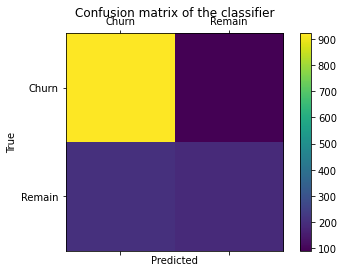

In [1026]:
# plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
# plt.title('Normalized Matrix')
labels = ['Churn', 'Remain']


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(pl)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [1027]:
print(pl)

[[921  91]
 [206 189]]


In [1031]:
fn,tp = pl[0][1], pl[0][0]
fnr_kmeans = fn / (tp + fn)
tpr_kmeans = tp / (tp + fn)
fnr_kmeans, tpr_kmeans

(0.08992094861660078, 0.9100790513833992)

In [1032]:
auc_kmeans = roc_auc_score(y_test, y_pred)
acc_kmeans = accuracy_score(y_test,y_pred)
print(auc_kmeans, acc_kmeans, fnr_kmeans, tpr_means)

0.6942800320208135 0.7889125799573561 0.08992094861660078 0.9100790513833992


As we can see, this model is alright, but we can likely do better with a different model. 

#### Ridge Classifier

In [1004]:
from sklearn.model_selection import RepeatedStratifiedKFold

ridge = RidgeClassifier()

alphas = [0.1, 0.3, 0.5, 0.7, 0.9]

param_grid = dict(alpha=alphas)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid = GridSearchCV(ridge, param_grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

search = grid.fit(X_train, y_train)

search.best_params_

{'alpha': 0.1}

In [1005]:
ridge = RidgeClassifier(alpha=0.1)

ridge.fit(X_train, y_train)

RidgeClassifier(alpha=0.1)

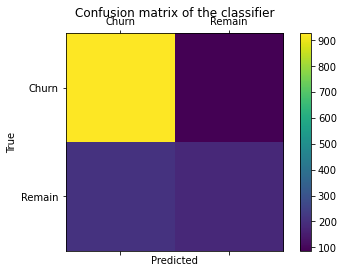

In [1038]:
y_pred = ridge.predict(X_test)

pl = confusion_matrix(y_test,y_pred)

labels = ['Churn', 'Remain']


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(pl)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [1039]:
print(pl)

[[925  87]
 [211 184]]


In [1040]:
fn,tp = pl[0][1], pl[0][0]
fnr_ridge = fn / (tp + fn)
tpr_ridge = tp / (tp + fn)
fnr_ridge, tpr_ridge

(0.08596837944664032, 0.9140316205533597)

In [1041]:
auc_ridge = roc_auc_score(y_test, y_pred)
acc_ridge = accuracy_score(y_test,y_pred)
print(auc_ridge, acc_ridge, fnr_ridge, tpr_ridge)

0.6899272026817431 0.7882018479033405 0.08596837944664032 0.9140316205533597


#### SVC

In [1033]:
svc = SVC()

kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=svc, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

print(grid_result.best_params_)

{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}


In [1034]:
svc = SVC(C=1, gamma='scale', kernel='rbf')

svc.fit(X_train, y_train)

SVC(C=1)

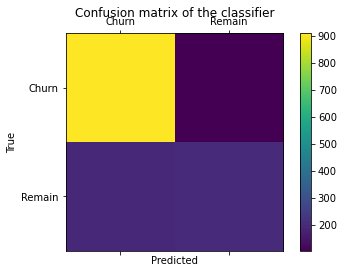

In [1042]:
y_pred = svc.predict(X_test)

pl = confusion_matrix(y_test,y_pred)

labels = ['Churn', 'Remain']


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(pl)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [1043]:
print(pl)

[[909 103]
 [197 198]]


In [1044]:
fn,tp = pl[0][1], pl[0][0]
fnr_svc = fn / (tp + fn)
tpr_svc = tp / (tp + fn)
fnr_svc, tpr_svc

(0.10177865612648221, 0.8982213438735178)

In [1045]:
auc_svc = roc_auc_score(y_test, y_pred)
acc_svc = accuracy_score(y_test,y_pred)
print(auc_svc, acc_svc, fnr_svc, tpr_svc)

0.699743583329164 0.7867803837953091 0.10177865612648221 0.8982213438735178


## Deep learning modeling using Keras

In [1046]:
from keras.layers import Dense
from keras.models import Sequential
from IPython.display import SVG
from keras.optimizers import Adam
from keras import regularizers
from keras.utils.vis_utils import model_to_dot
from keras import losses
#import pydot
from keras.utils.vis_utils import plot_model

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_123 (Dense)            (None, 64)                384       
_________________________________________________________________
dense_124 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_125 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_126 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_127 (Dense)            (None, 1)                 9         
Total params: 3,137
Trainable params: 3,137
Non-trainable params: 0
_________________________________________________________________


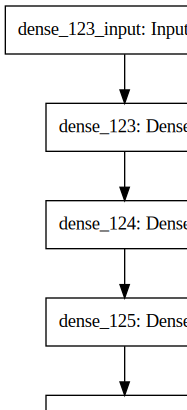

In [1047]:
n_cols=X_train.shape[1]
seq = Sequential()
seq.add(Dense(64, input_shape=(n_cols,), activation='relu'))
seq.add(Dense(32, activation='relu'))
seq.add(Dense(16, activation='relu'))
seq.add(Dense(8, activation='relu'))
seq.add(Dense(1, activation='sigmoid'))

seq.compile(loss='binary_crossentropy', optimizer='adam')
seq.summary()

#plot the a graph
SVG(model_to_dot(seq).create(prog='dot', format='svg'))

In [1048]:
seq.fit(X_train, y_train)
predictions   = seq.predict(X_test)
probabilities = seq.predict_proba(X_test)

seq_roc_auc = roc_auc_score(y_test,predictions) 
print ("Area under curve : ",seq_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probabilities)

176/176 [==============================] - 0s 1ms/step - loss: 0.4785
Area under curve :  0.8349627257717516 



In [1049]:
import plotly.graph_objects as go
#plot roc curve
trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(seq_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))


In [1050]:
import plotly.tools as tls
import plotly as py

fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('',
                                            'ROC',
                                            ''))

fig.append_trace(trace2,1,2)
fig.append_trace(trace3,1,2)

py.offline.iplot(fig)


In [1051]:
acc_sequential = accuracy_score(y_test, predictions.round())

acc_sequential

0.7938877043354655

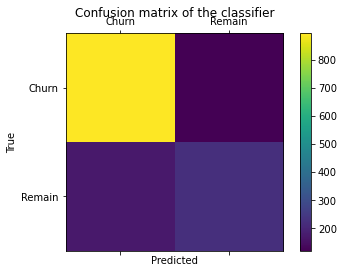

In [1052]:
pl = confusion_matrix(y_test,predictions.round())

labels = ['Churn', 'Remain']


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(pl)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [1053]:
pl

array([[894, 118],
       [172, 223]], dtype=int64)

In [1054]:
fn,tp = pl[0][1], pl[0][0]
fnr_seq = fn / (tp + fn)
tpr_seq = tp / (tp + fn)
fnr_seq, tpr_seq

(0.116600790513834, 0.883399209486166)

## Conclusions

We have created 4 classification models and will compare the results. First, we look at the table of ROC-AUC scores and accuracy scores to see which are the best at predicting the churn of customers.

In [1055]:
scores = pd.DataFrame([['K Means', auc_kmeans, acc_kmeans, fnr_kmeans, tpr_kmeans], 
                       ['Ridge', auc_ridge, acc_ridge, fnr_ridge, tpr_ridge],
                       ['SVC', auc_svc, acc_svc, fnr_svc, tpr_svc],
                       ['Sequential NN', seq_roc_auc, acc_sequential, fnr_seq, tpr_seq]],
                      columns=['Model', 'ROC_AUC_Score', 'Accuracy_Score', 'False Negative Rate', 'True Positive Rate']
            )
scores

,Model,ROC_AUC_Score,Accuracy_Score,False Negative Rate,True Positive Rate
0,K Means,0.694280,0.788913,0.101779,0.898221
1,Ridge,0.689927,0.788202,0.085968,0.914032
2,SVC,0.699744,0.786780,0.101779,0.898221
3,Sequential NN,0.834963,0.793888,0.116601,0.883399


We see in our table of scoring that the Sequential NN has the best ROC_AUC score, but is not necessarily the most accurate. Of the models that are not neural networks, it appears that the KMeans and SVC models work identically well, while the Ridge model is slightly less accurate and has a lower ROC_AUC_Score. We conclude that we should use the Sequential NN or the KMeans models for our final assessments.

In [972]:
from sklearn.model_selection import cross_val_score, cross_validate

models = [knn, ridge, svc]

for m in models:
    cv_res = cross_val_score(m, X, y, scoring='accuracy', cv = 10)
    print(str(m) + ': '+ str(cv_res.mean()))

KNeighborsClassifier(n_neighbors=41): 0.729663253265227
RidgeClassifier(alpha=0.1): 0.8040386977886979
SVC(C=1): 0.7342149715504978


KNeighborsClassifier(n_neighbors=41): 0.678946 (0.377039)
RidgeClassifier(alpha=0.1): 0.727661 (0.243176)
SVC(C=1): 0.734424 (0.415297)


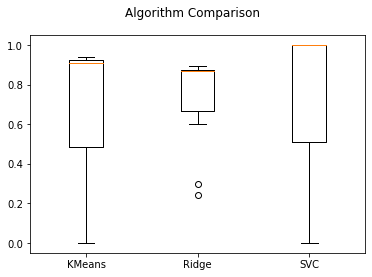

In [973]:
from sklearn import model_selection
results = []
names = ['KMeans', 'Ridge', 'SVC']

for m in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(m, X, y, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    msg = "%s: %f (%f)" % (str(m), cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [974]:
cv_results = cross_validate(ridge, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
cv_results['test_score']

array([-0.19616205, -0.18123667, -0.20981508, -0.19345661, -0.19772404])

In [975]:
cv_results = cross_validate(svc, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
cv_results['test_score']

array([-0.26581379, -0.26581379, -0.26600284, -0.26600284, -0.26529161])

In [976]:
cv_results = cross_validate(knn, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
cv_results['test_score']

array([-0.26297086, -0.27789623, -0.26315789, -0.27382646, -0.26742532])

In [978]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [981]:
seq.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

history = seq.fit(X_train, y_train, validation_split=0.3, epochs=10, verbose=0)

loss, accuracy, f1_score, precision, recall = seq.evaluate(X_test, y_test, verbose=0)

In [982]:
print(loss, accuracy, f1_score, precision, recall)

0.43749088048934937 0.7924662232398987 0.5550104379653931 0.6847838759422302 0.49886101484298706


In [983]:
# Save the best model in best_model
best_model = knn

## Model evaluation

In [737]:
prediction_list = ridge.predict(X)

In [744]:
df_data = X.copy()
df_data['Prediction'] = prediction_list
df_data['Churn Value'] = y

In [745]:
df_data['Count'] = 1

In [746]:
df_data.head()

,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,...,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,Prediction,Churn Value,Count
CustomerID,,,,,,,,,,,,,,,,,,,,,
3668-QPYBK,90003,33.964131,-118.272783,0,0,0,0,2,1,0,...,1,0,0,0,0,0,1,1,1,1
9237-HQITU,90005,34.059281,-118.307420,1,0,0,1,2,1,0,...,1,0,0,0,0,1,0,1,1,1
9305-CDSKC,90006,34.048013,-118.293953,1,0,0,1,8,1,1,...,1,0,0,0,0,1,0,1,1,1
7892-POOKP,90010,34.062125,-118.315709,1,0,1,1,28,1,1,...,1,0,0,0,0,1,0,1,1,1
0280-XJGEX,90015,34.039224,-118.266293,0,0,0,1,49,1,1,...,1,0,0,1,0,0,0,0,1,1


In [747]:
false_data = df_data[df_data['Churn Value'] != df_data['Prediction']]
false_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3999 entries, 0280-XJGEX to 4801-JZAZL
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Zip Code                                  3999 non-null   int64  
 1   Latitude                                  3999 non-null   float64
 2   Longitude                                 3999 non-null   float64
 3   Gender                                    3999 non-null   int64  
 4   Senior Citizen                            3999 non-null   int64  
 5   Partner                                   3999 non-null   int64  
 6   Dependents                                3999 non-null   int64  
 7   Tenure Months                             3999 non-null   int64  
 8   Phone Service                             3999 non-null   int64  
 9   Multiple Lines                            3999 non-null   int64  
 10  Online Security           

In [749]:
false_data.groupby('Prediction').count()

,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,...,Internet Service_No,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,Churn Value,Count
Prediction,,,,,,,,,,,,,,,,,,,,,
0,243,243,243,243,243,243,243,243,243,243,...,243,243,243,243,243,243,243,243,243,243
1,3756,3756,3756,3756,3756,3756,3756,3756,3756,3756,...,3756,3756,3756,3756,3756,3756,3756,3756,3756,3756


In [ ]:
false_zips = false_data.groupby('Zip Code')['Count'].count().sort_values(ascending=False)

type(false_zips)

In [ ]:
false_zips = pd.DataFrame(false_zips)

false_zips.reset_index(inplace=True)

In [ ]:
false_zips['Zip Code'].sort_values(ascending=False)

In [ ]:
df_churn = pd.read_excel('data/Telco_customer_churn.xlsx')

df_churn.head()

In [ ]:
from uszipcode import SearchEngine, SimpleZipcode, Zipcode
search = SearchEngine()

In [ ]:
def zco(x):
    if pd.isnull(x):
        return None
    else:
        city = search.by_zipcode(x)
        return city.major_city

In [ ]:
false_zips['City'] = false_zips['Zip Code'].apply(zco)
false_zips.head()

In [ ]:
import folium
import pandas as pd
import json
from folium import plugins

In [ ]:
false_zips['Zip Code'] = false_zips['Zip Code'].astype('str')

In [ ]:
false_zips.info()

In [ ]:
ca_map = folium.Map(location=[38, -121.4944], zoom_start=6)

ca_map.choropleth(geo_data="data/ca_california_zip_codes_geo.min.json",
             data=false_zips, # my dataset
             columns=['Zip Code', 'Count'], # zip code is here for matching the geojson zipcode, predictions is the column that changes the color of zipcode areas
             key_on='feature.properties.ZCTA5CE10', # this path contains zipcodes in str type, this zipcodes should match with our ZIP CODE column
             fill_color='BuPu', fill_opacity=0.8, line_opacity=0.5,
             legend_name='Count')

In [ ]:
ca_map